In [54]:
from dataclasses import astuple
import os
from pathlib import Path 
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.insert(0, str(Path().absolute().parents[1]))

from experiments.datasets.faces import FaceImage, FaceAnnotation

In [55]:
data_dir = os.environ.get("DATASETS")
data_dir = Path(data_dir) / "FDDB"
faces_dir = data_dir / "originalPics"
fold_dir = data_dir / "FDDB-folds"

fold_id = 1

fold_file = fold_dir / f"FDDB-fold-{fold_id:02d}.txt"
fold_ellipse_file = fold_dir / f"FDDB-fold-{fold_id:02d}-ellipseList.txt"

In [56]:
test_fold = 10
val_folds = [8, 9]
train_folds = [1, 2, 3, 4, 5, 6, 7]

In [57]:
# total_imgs = 0
# for fold_file_ in sorted(fold_dir.glob("FDDB-fold-*")):
#     if fold_file_.name.endswith("ellipseList.txt"):
#         continue
    
#     with open(fold_file_, "r") as fid:
#         fold_imgs = fid.read().splitlines()
#         print(len(fold_imgs))
#         total_imgs += len(fold_imgs)

#     print(fold_file_)

# print(total_imgs)

with open(fold_file, "r") as fid:
    fold_imgs = fid.read().splitlines()

In [58]:
face_images: list[FaceImage] = []

with open(fold_ellipse_file, "r") as fid:
    while True:
        line = fid.readline()
        
        if not line:
            break

        if line.endswith("\n"):
            line = line[:-1]

        assert line.startswith("2002") or line.startswith("2003")
        assert line in fold_imgs
        
        face_img_path = faces_dir / (line + ".jpg")
        num_faces = int(fid.readline())
        face_img = FaceImage(file_path=face_img_path, num_faces=num_faces)
        
        for _ in range(num_faces):
            face_anno = FaceAnnotation.from_str(fid.readline())
            face_img.add_face(face_anno)

        face_images.append(face_img)

In [59]:
img_with_most_faces = face_images[0]
for face_img in face_images[1:]:
    if face_img.num_faces > img_with_most_faces.num_faces:
        img_with_most_faces = face_img

k = 5
img_with_k_faces = None
for face_img in face_images:
    if face_img.num_faces == k:
        img_with_k_faces = face_img
        break

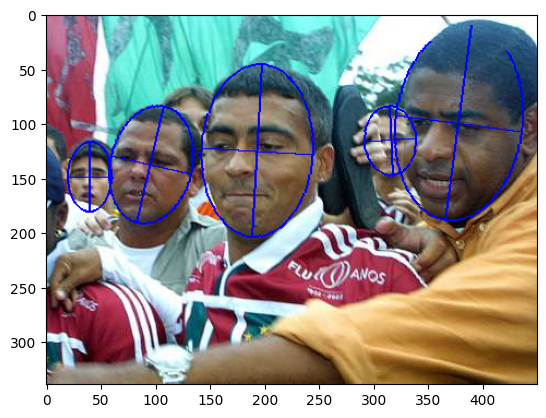

In [60]:
face_img = img_with_k_faces # face_images[240]  # img_with_most_faces
img = face_img.show_annotated_image()
plt.imshow(img)

Reducing non face size
Reducing non face size
Reducing non face size
Reducing non face size
Reducing non face size
Reducing non face size
Reducing non face size


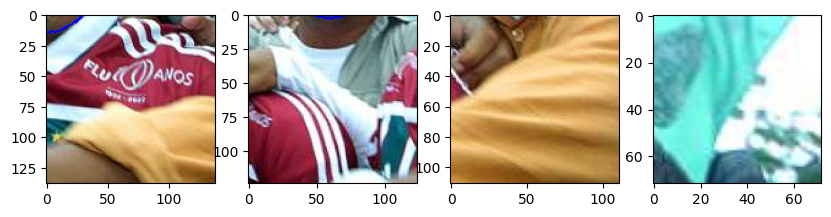

In [61]:
num_instances = None
res = face_img.crop_non_face_img(
    seed=12345, max_overlap=0.1, num_instances=num_instances
)

fig, axes = plt.subplots(1, len(res), figsize=(10, 5))

for ax, rect in zip(axes.flatten(), res):
    ax.imshow(
        np.asarray(img)[
            rect.top_left_y:rect.bot_right_y,
            rect.top_left_x:rect.bot_right_x, 
            :
        ]
    )

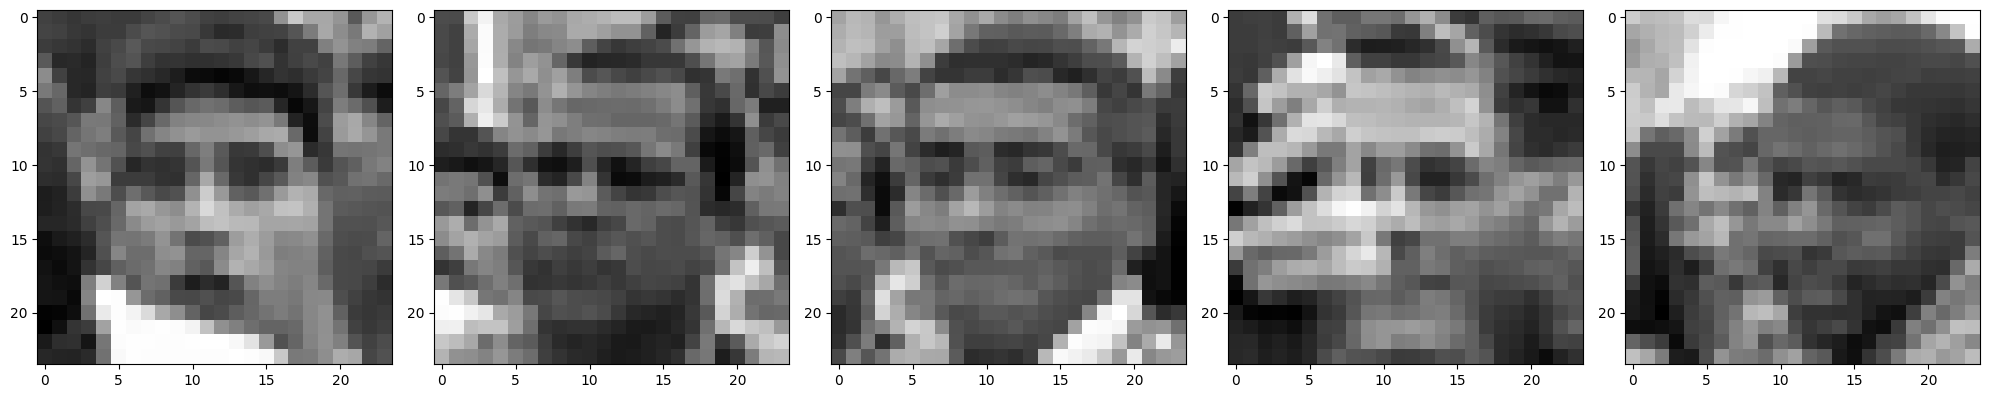

In [62]:
num_faces = face_img.num_faces

fig, axes = plt.subplots(1, num_faces, figsize=(20, 5))
for ax, cropped_face in zip(axes.flatten(), face_img.get_all_croped_faces()):
    ax.imshow(cropped_face.resize((24, 24)).convert("L"), cmap="gray")
    ax.set_aspect("equal")
fig.tight_layout()